In [2]:
%matplotlib inline

In [3]:
import os
import glob
import re
import pandas as pd
import numpy as np

In [4]:
def load_data(dataset):
    df = pd.read_csv(f'results/r_{dataset}.csv', index_col=0)
    return df

In [5]:
def compute_metrics(df):
    df['discover_rate'] = df.infected_known / df.infected

In [6]:
def print_summary(dataset):
    df = load_data(dataset)
    display(df.tail(1))
    df.plot(figsize=(16,10))

In [7]:
def get_newest_files():
    files = glob.glob('results/*.csv')
    files.sort(key=os.path.getctime, reverse=True)
    files = map(lambda x: os.path.basename(x), files)
    files = map(lambda x: os.path.basename(x), files)
    files = map(lambda x: os.path.splitext(x)[0], files)
    files = map(lambda x: re.match(r'^r_(?P<id>.*)', x).group('id'), files)
    return list(files)

In [8]:
get_newest_files()

['f3f25677cdad10fbedf8c3057f77c0a7772a279b',
 '87ba5323e3047041c7a79118caba858ddea28974',
 '9fd6bec40aa03808578b2e4532ffd31aaf5e0e81',
 'a53682cd05f24903f865c25e321c7943bdab386e',
 '1613915527',
 '1613915334',
 '1613841500',
 '1613841169',
 '1613840819',
 '1613840532',
 '1613840355',
 '1613838639',
 '1613838431',
 '1613838353',
 '1613838008',
 '1613837912',
 '1613837825',
 '1613837416',
 '1613836677',
 '1613825408',
 '1613824242',
 '1613818803',
 '1613818409',
 '1613818116',
 '1613817919',
 '1613817081',
 '1613817655',
 '1613816566',
 '1613816128',
 '1613815657',
 '1613812161',
 '1613765968',
 '1613760512',
 '1613759959']

,infected,recovered,fatalities,infected_known,susceptible
899,0,271,32,0,1697


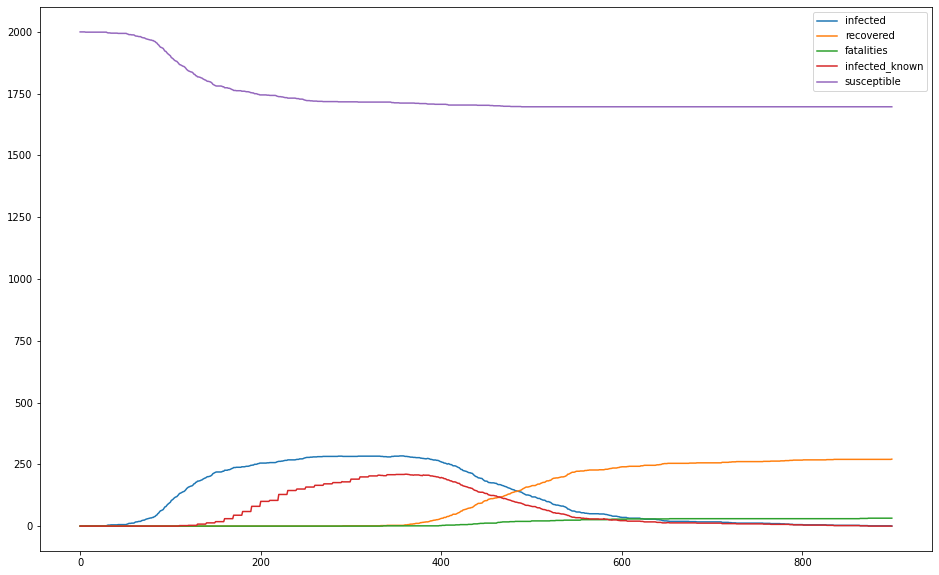

In [19]:
print_summary('1613817655')

,infected,recovered,fatalities,infected_known,susceptible
1142,0,700,74,0,1226


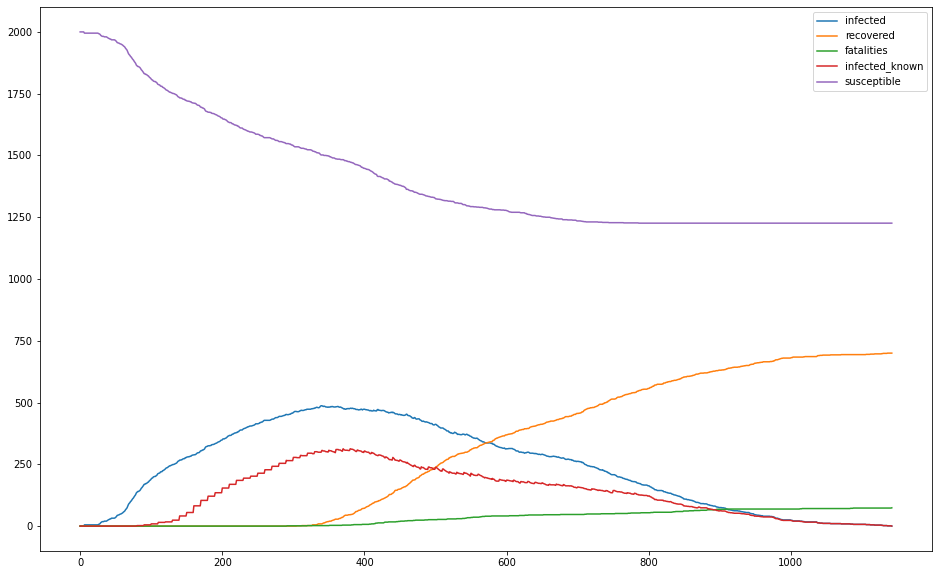

In [22]:
print_summary('1613817919')

,infected,recovered,fatalities,infected_known,susceptible
668,0,208,11,0,1781


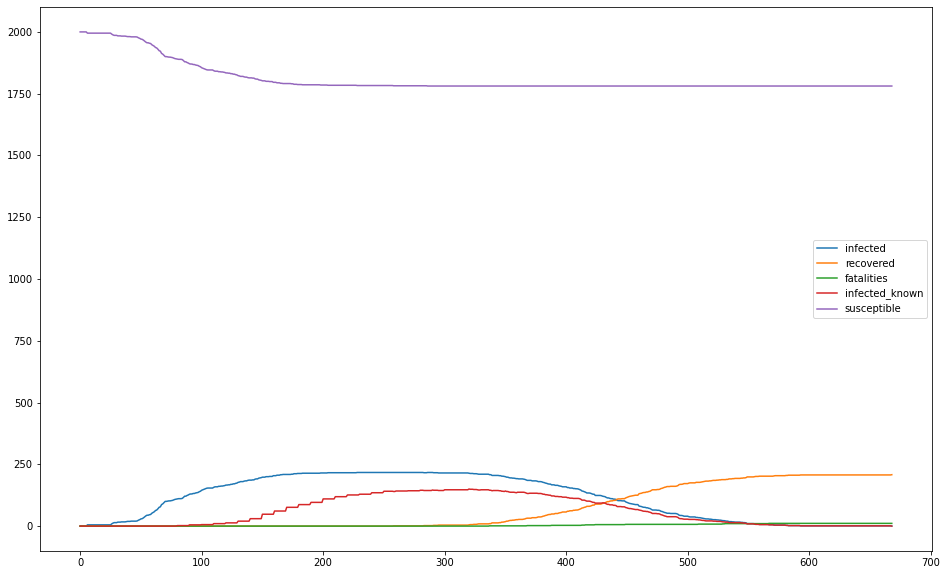

In [23]:
print_summary('1613818116')

,infected,recovered,fatalities,infected_known,susceptible
986,0,1837,140,0,23


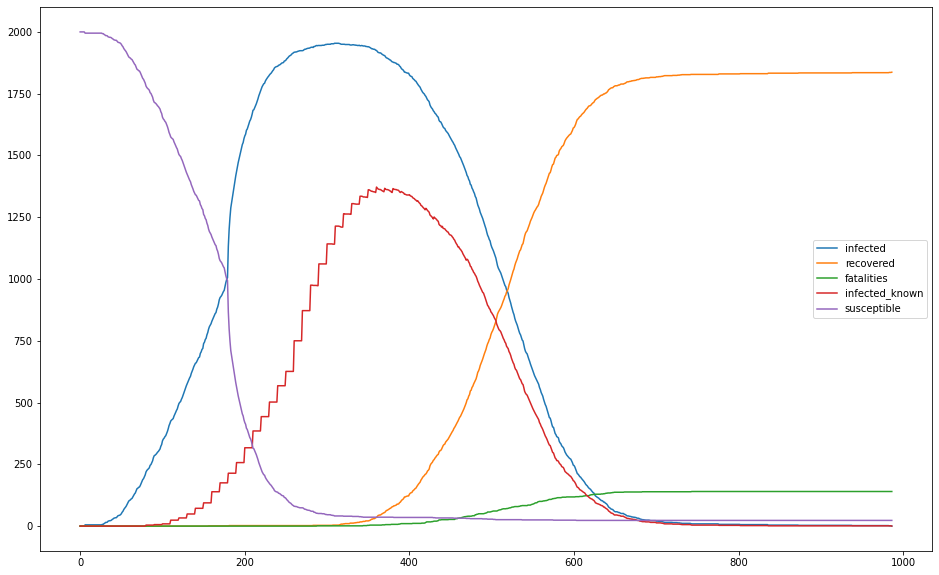

In [24]:
print_summary('1613818409')

,infected,recovered,fatalities,infected_known,susceptible
1098,0,869,59,0,1072


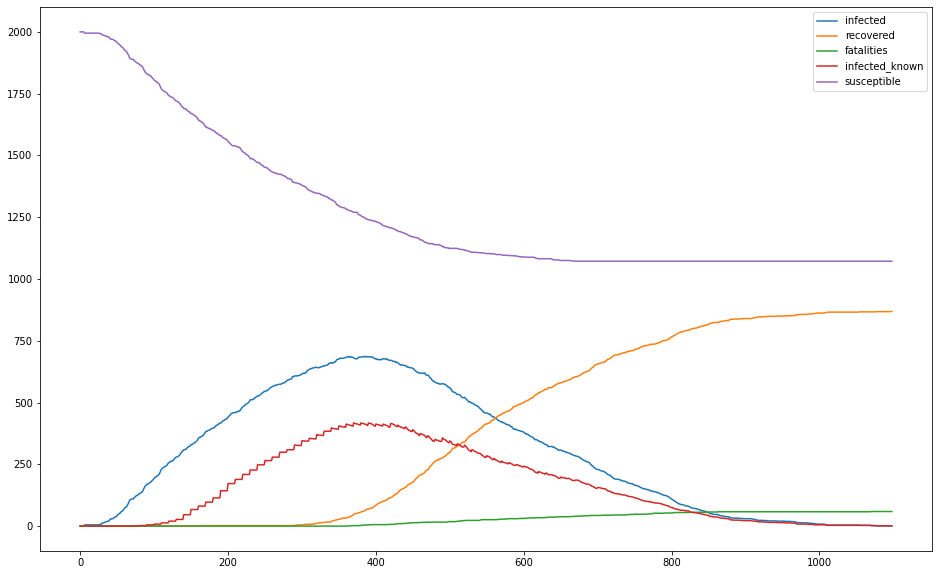

In [61]:
print_summary('1613818803')

,infected,recovered,fatalities,infected_known,susceptible,severity0,severity1,severity2
1161,0,742,77,0,1181,257,368,193


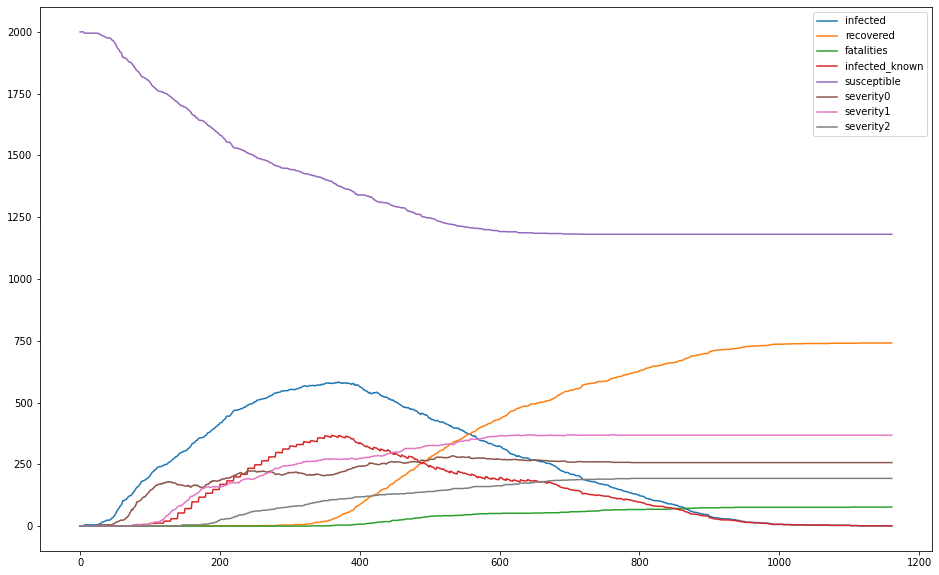

In [71]:
print_summary('1613825408')

In [67]:
df = load_data('1613818803')
df.head()

,infected,recovered,fatalities,infected_known,susceptible
0,0,0,0,0,2000
1,0,0,0,0,2000
2,0,0,0,0,2000
3,0,0,0,0,2000
4,0,0,0,0,2000


In [68]:
df['%'] = df.infected_known/df.infected
df

,infected,recovered,fatalities,infected_known,susceptible,%
0,0,0,0,0,2000,NaN
1,0,0,0,0,2000,NaN
2,0,0,0,0,2000,NaN
3,0,0,0,0,2000,NaN
4,0,0,0,0,2000,NaN
...,...,...,...,...,...,...
1094,1,868,59,1,1072,1.0
1095,1,868,59,1,1072,1.0
1096,1,868,59,1,1072,1.0
1097,1,868,59,1,1072,1.0


<AxesSubplot:>

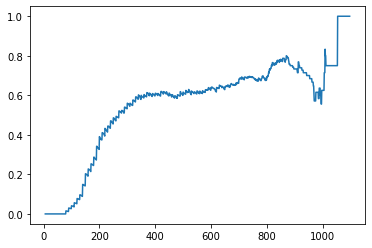

In [75]:
df['%'].plot()

In [76]:
df['%'].describe()

count    1092.000000
mean        0.554316
std         0.244826
min         0.000000
25%         0.517973
50%         0.615385
75%         0.690909
max         1.000000
Name: %, dtype: float64

- proportion wearing masks 0.5 (0.1, 0.95)
- test start proportion 0.05 (0.01, 0.1)
- self isolate proportion 0.7 (0.1, 0.95)
- tests daily proportion min 0.005 (0.001, 0.01)
- tests daily proportion max 0.05 (0.01, 0.1)
- desired_positive_proportion 0.1 (0.01, 0.5)
- healthcare capacity (ewentualnie) 100 (50, 150)
- speed 0.01 (0.005, 0.04)

- severity2 count
- dead count
- unaffected count
- 75% discover rate (min 25%)

In [79]:
np.array([1,2,3])[[1,2]]

array([2, 3])

<AxesSubplot:>

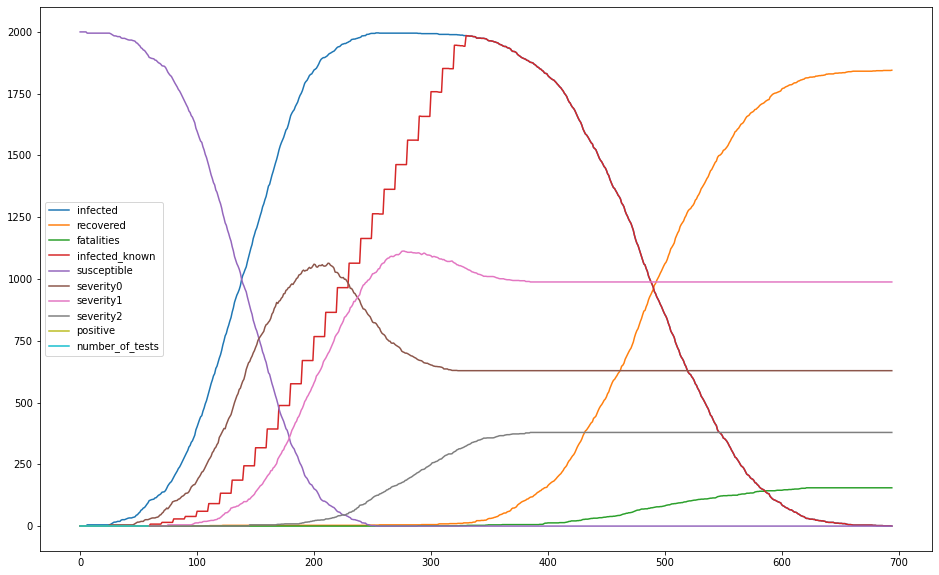

In [113]:
df = load_data('1613838353')
df.plot(figsize=(16,10))

<AxesSubplot:>

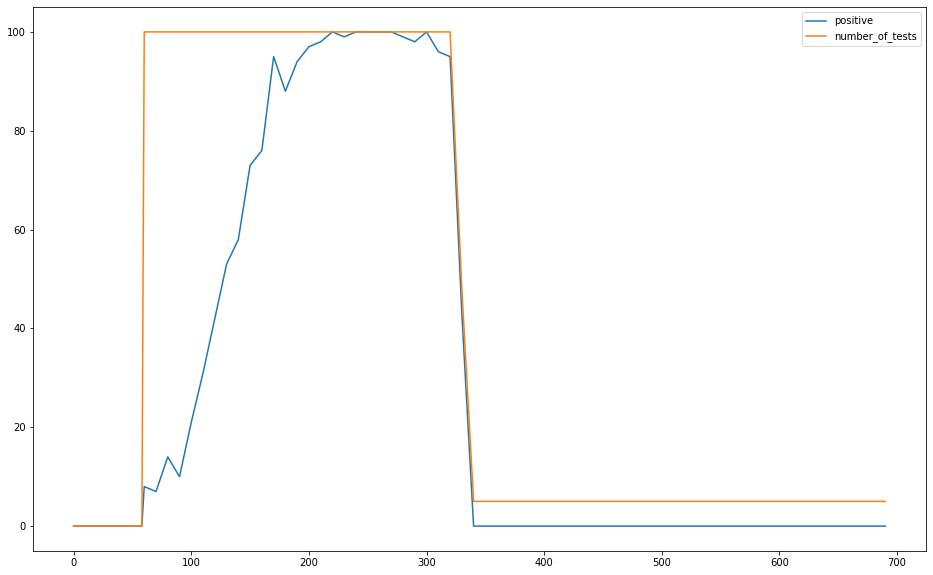

In [114]:
df = load_data('1613838353')
df = df[['positive', 'number_of_tests']]
df.dropna(inplace=True)
df.plot(figsize=(16,10))

<AxesSubplot:>

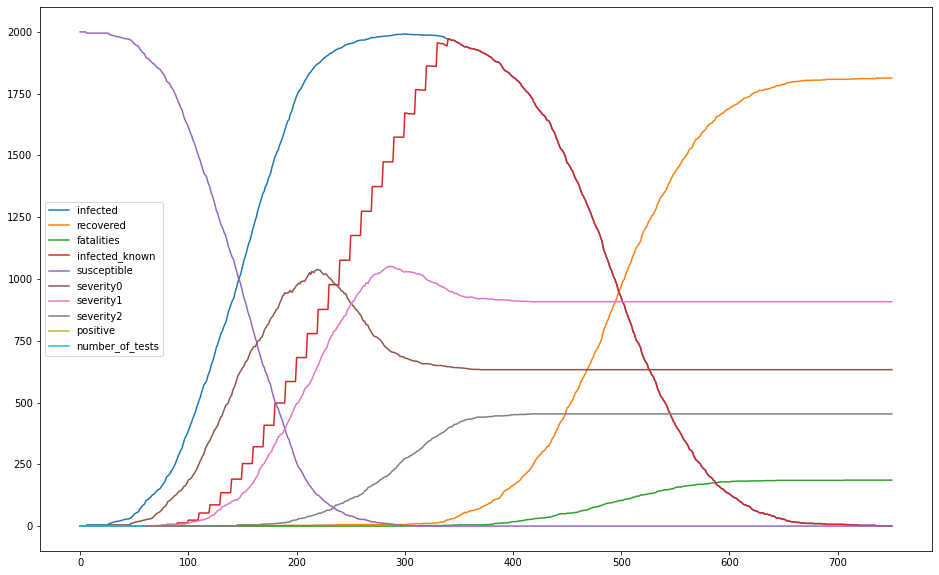

In [126]:
df = load_data('1613840355')
df.plot(figsize=(16,10))

<AxesSubplot:>

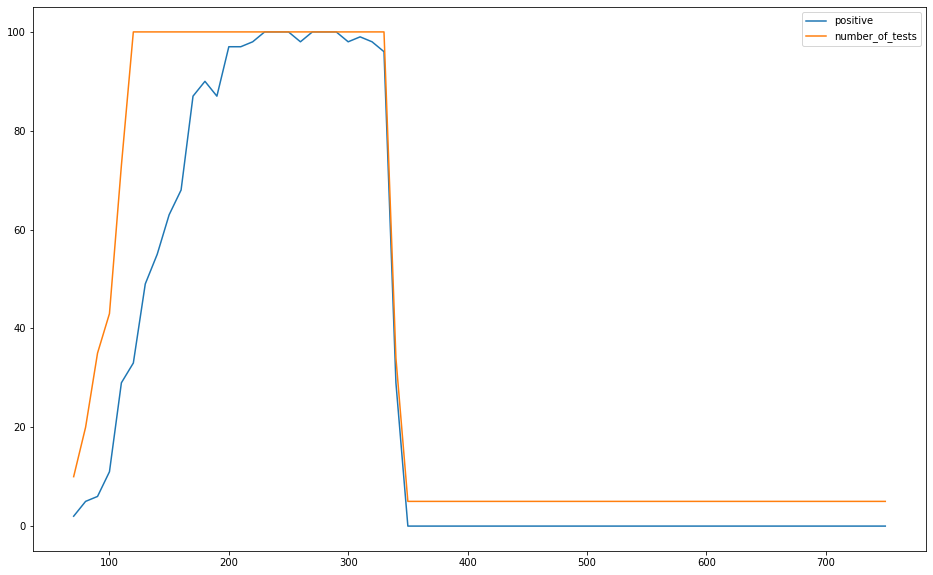

In [127]:
df = load_data('1613840355')
df = df[['positive', 'number_of_tests']]
df.dropna(inplace=True)
df.plot(figsize=(16,10))

<AxesSubplot:>

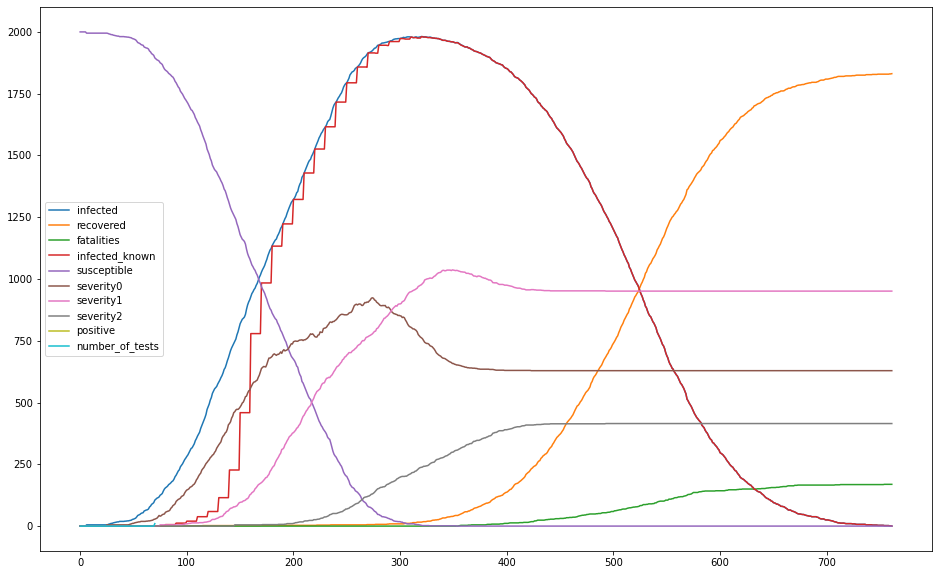

In [128]:
df = load_data('1613840532')
df.plot(figsize=(16,10))

<AxesSubplot:>

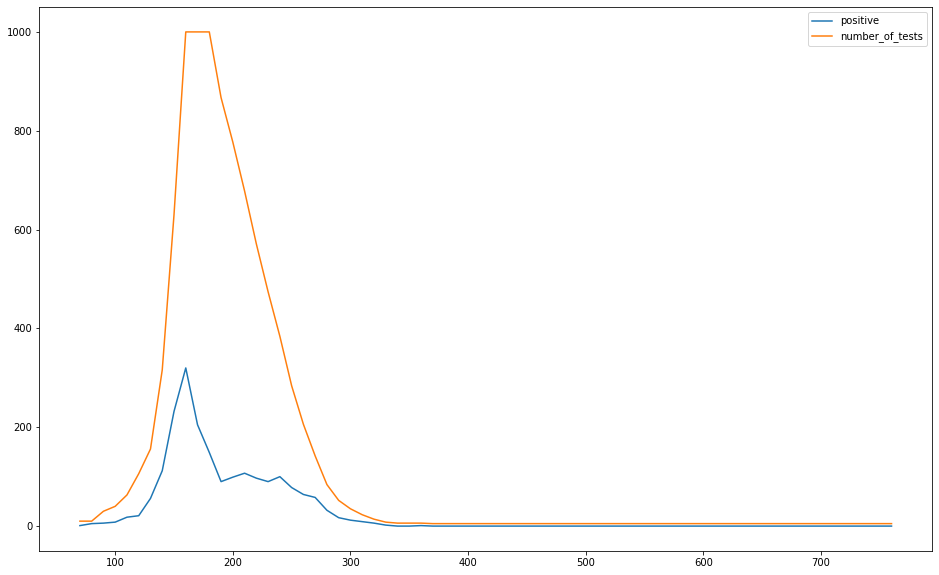

In [129]:
df = load_data('1613840532')
df = df[['positive', 'number_of_tests']]
df.dropna(inplace=True)
df.plot(figsize=(16,10))

<AxesSubplot:>

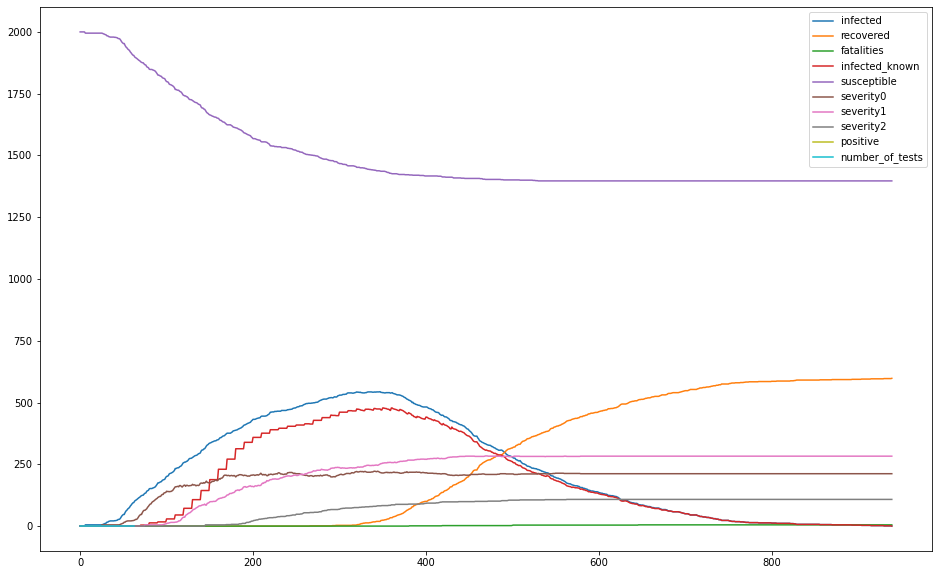

In [130]:
df = load_data('1613841169')
df.plot(figsize=(16,10))

<AxesSubplot:>

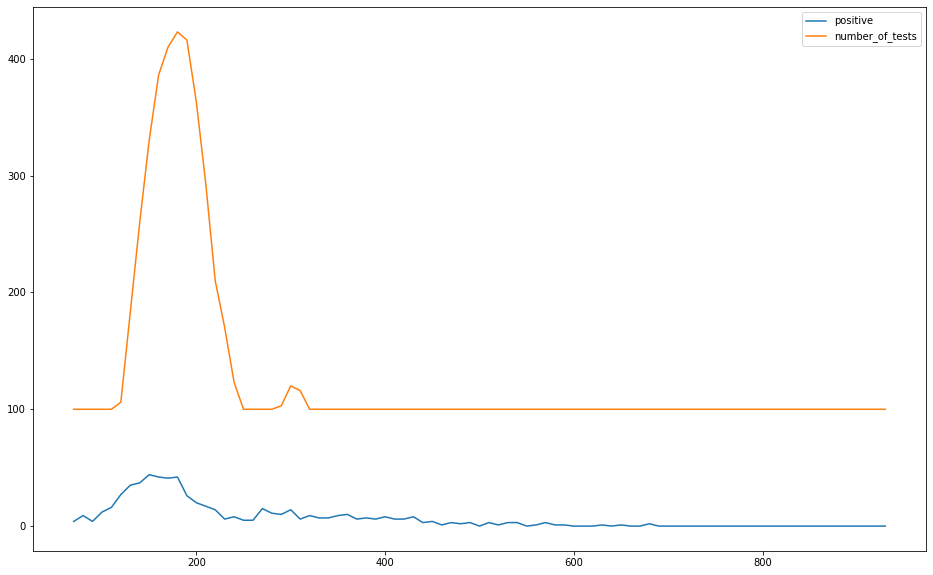

In [131]:
df = load_data('1613841169')
df = df[['positive', 'number_of_tests']]
df.dropna(inplace=True)
df.plot(figsize=(16,10))

<AxesSubplot:>

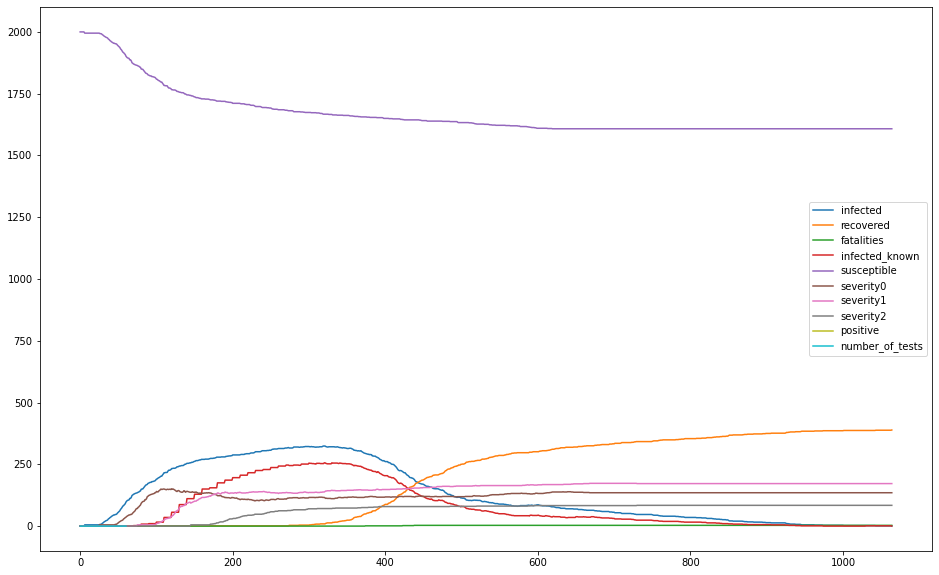

In [132]:
df = load_data('1613841500')
df.plot(figsize=(16,10))

<AxesSubplot:>

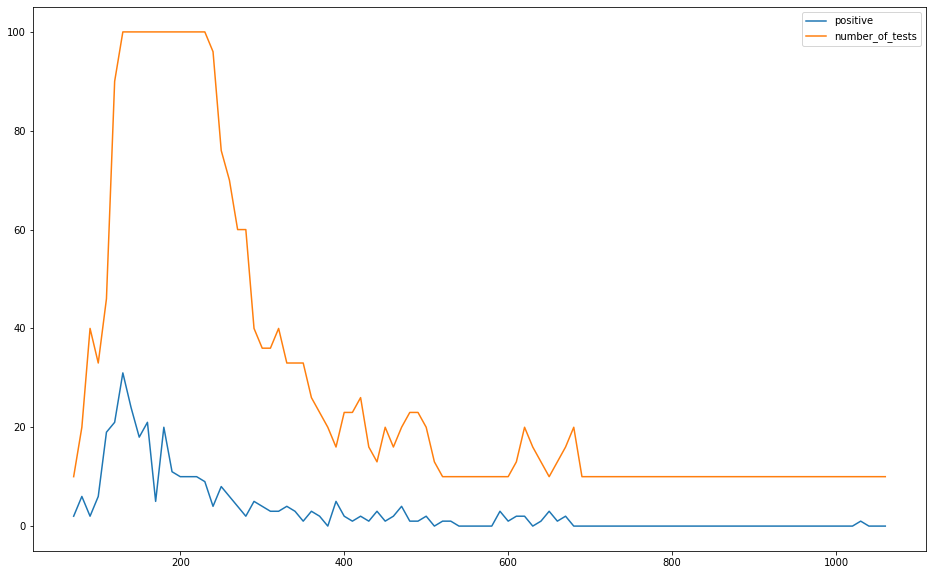

In [133]:
df = load_data('1613841500')
df = df[['positive', 'number_of_tests']]
df.dropna(inplace=True)
df.plot(figsize=(16,10))

<AxesSubplot:>

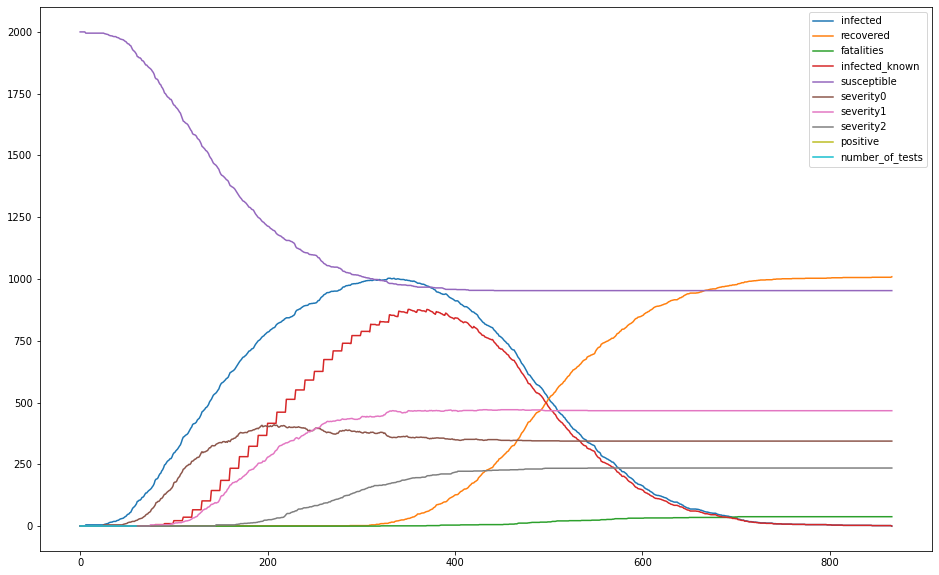

In [9]:
df = load_data('87ba5323e3047041c7a79118caba858ddea28974')
df.plot(figsize=(16,10))

<AxesSubplot:>

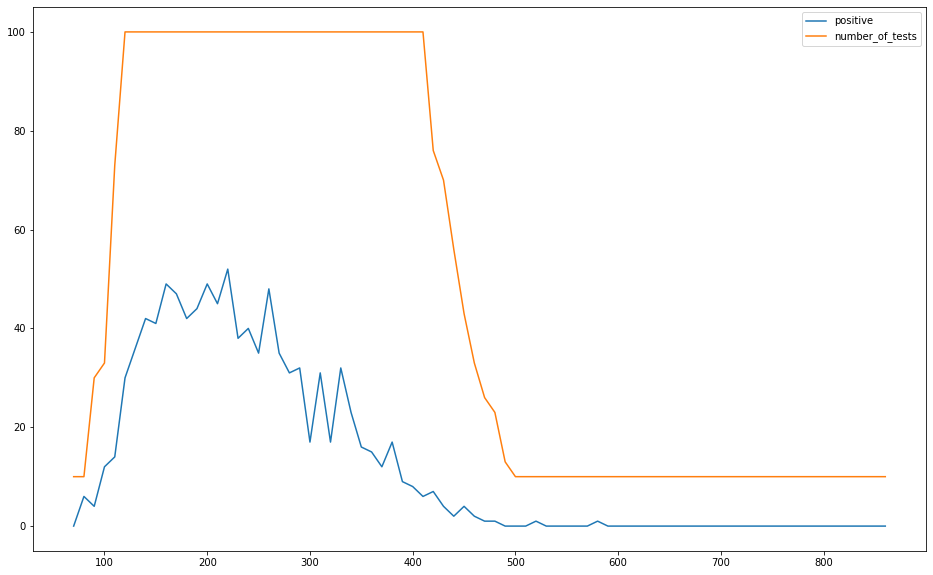

In [10]:
df = load_data('87ba5323e3047041c7a79118caba858ddea28974')
df = df[['positive', 'number_of_tests']]
df.dropna(inplace=True)
df.plot(figsize=(16,10))